https://finance.yahoo.com/quote/KO/

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Descargar datos históricos de KO (Coca-Cola) desde Yahoo Finance
symbol = "KO"
data = yf.download(symbol, start="2024-01-01", end="2025-04-01")
data.columns

[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'KO'),
            (  'High', 'KO'),
            (   'Low', 'KO'),
            (  'Open', 'KO'),
            ('Volume', 'KO')],
           names=['Price', 'Ticker'])

In [19]:
# Renombrar las columnas eliminando el MultiIndex y aplicando snake_case
data.columns = [f"{col[0].lower()}_{col[1].lower()}" for col in data.columns]

# Mostrar las nuevas columnas
print(data.head())

             close_ko    high_ko     low_ko    open_ko  volume_ko
Date                                                             
2024-01-02  57.621925  57.679722  56.514180  56.639405   16322600
2024-01-03  57.756779  57.987962  57.564127  57.727882   14830600
2024-01-04  57.564125  58.045753  57.467801  57.843470   12912900
2024-01-05  57.477432  57.747146  56.918746  57.602656   10411400
2024-01-08  57.901264  57.968692  57.236616  57.487064   11554600


In [23]:
# Usamos solo el precio de cierre ajustado
df = data[['close_'+symbol.lower()]]
df = df.rename(columns={'close_'+symbol.lower(): 'close'})
df.head(2)

,close
Date,
2024-01-02,57.621925
2024-01-03,57.756779


Primeras filas del dataset:
             close_ko    high_ko     low_ko    open_ko  volume_ko
Date                                                             
2024-01-02  57.621925  57.679722  56.514180  56.639405   16322600
2024-01-03  57.756779  57.987962  57.564127  57.727882   14830600
2024-01-04  57.564125  58.045753  57.467801  57.843470   12912900
2024-01-05  57.477432  57.747146  56.918746  57.602656   10411400
2024-01-08  57.901264  57.968692  57.236616  57.487064   11554600

Descripción estadística: KO
         close_ko     high_ko      low_ko     open_ko     volume_ko
count  312.000000  312.000000  312.000000  312.000000  3.120000e+02
mean    63.237452   63.626846   62.779867   63.194880  1.478730e+07
std      4.496761    4.567150    4.406139    4.464246  5.843904e+06
min     56.373932   56.684639   56.247706   56.558413  5.019100e+06
25%     59.672771   59.806281   59.155738   59.393621  1.112762e+07
50%     62.101717   62.627835   61.823767   62.146505  1.328595e+07
75%  

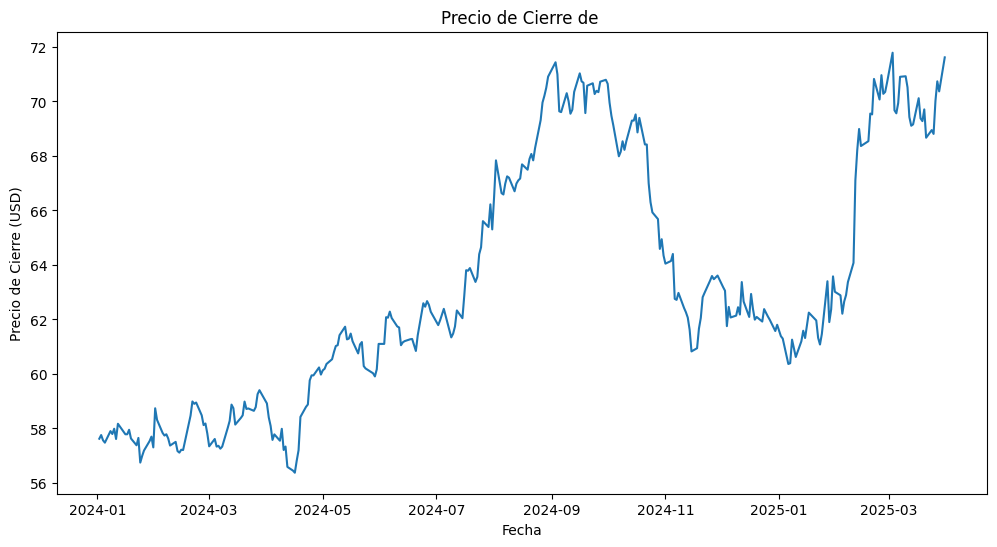

In [24]:
def analyze_data(data,symbol):
    """
    Analiza y muestra un resumen estadístico del conjunto de datos.
    """
    print("Primeras filas del dataset:")
    print(data.head())

    print(f"\nDescripción estadística: {symbol}")
    print(data.describe())

    plt.figure(figsize=(12, 6))
    plt.title('Precio de Cierre de ')
    plt.plot(df['close'])
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (USD)')
    plt.show()

analyze_data(data,symbol)

In [28]:

# Normalización de datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
df_scaled[0]

array([0.0809529])

In [33]:
# Crear secuencias de tiempo para entrenamiento
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Definir la longitud de la secuencia (días pasados usados para predecir)
SEQ_LENGTH = 60  # 60 días de datos para predecir el siguiente
X, y = create_sequences(df_scaled, SEQ_LENGTH)

In [34]:
from sklearn.model_selection import train_test_split

# Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Construcción del modelo LSTM en TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - loss: 0.2729 - val_loss: 0.0815
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0596 - val_loss: 0.0532
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0344 - val_loss: 0.0207
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0243 - val_loss: 0.0151
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0132 - val_loss: 0.0170
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0170 - val_loss: 0.0123
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0093 - val_loss: 0.0103
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0086 - val_loss: 0.0092


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step


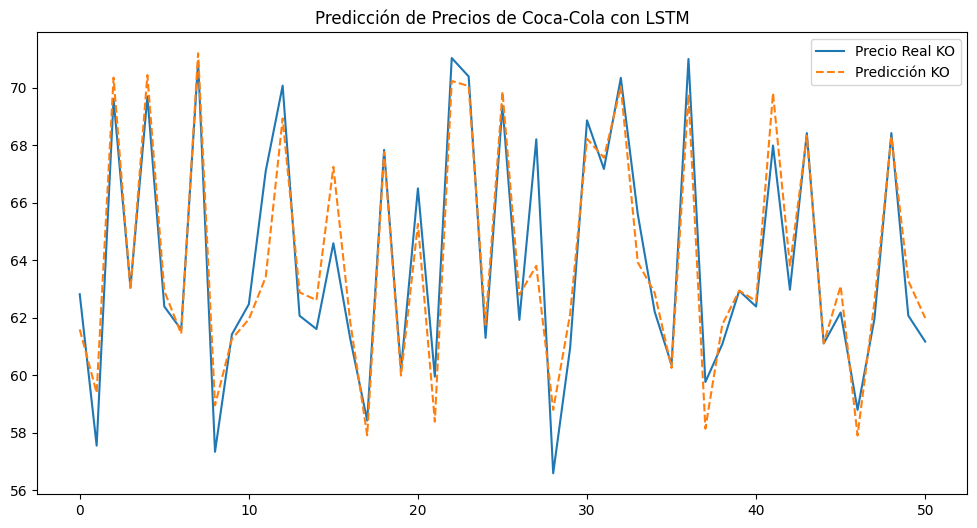

In [37]:
# Predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Invertir la escala de los valores reales
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizar los resultados
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Precio Real KO")
plt.plot(predictions, label="Predicción KO", linestyle="dashed")
plt.legend()
plt.title("Predicción de Precios de Coca-Cola con LSTM")
plt.show()

# HACIENDO PREDICCIONES PARA LOS PROXIMOS 30 DIAS

[[61.99021 ]
 [62.012897]
 [62.062164]
 [62.12961 ]
 [62.209553]
 [62.298008]
 [62.392128]
 [62.48989 ]
 [62.589813]
 [62.690853]
 [62.792255]
 [62.89351 ]
 [62.994225]
 [63.094162]
 [63.19313 ]
 [63.291004]
 [63.3877  ]
 [63.483143]
 [63.577282]
 [63.670067]
 [63.761456]
 [63.851425]
 [63.939934]
 [64.02696 ]
 [64.112465]
 [64.19643 ]
 [64.27881 ]
 [64.35961 ]
 [64.43881 ]
 [64.51638 ]]


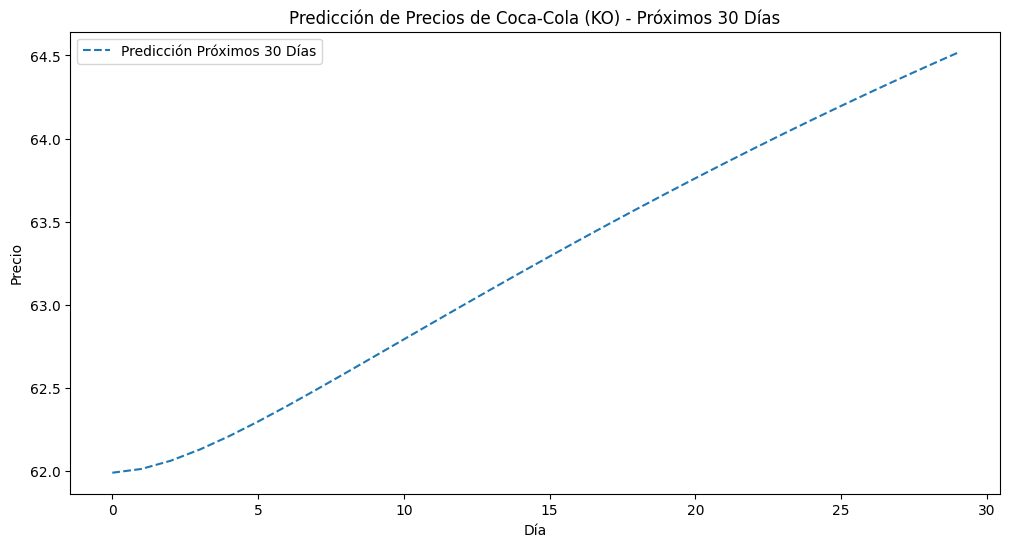

In [38]:
# Suponemos que tienes estas variables ya definidas:
# - model: tu modelo LSTM entrenado
# - scaler: el objeto de escalamiento usado anteriormente
# - X_test: últimos datos de entrada (por ejemplo, secuencia de los últimos 60 días)
# - dataset_scaled: el dataset completo escalado

# Usamos la última secuencia de entrada como punto de partida
last_sequence = X_test[-1]  # forma (60, número de características)
predictions_future = []

# Hacer predicciones para los siguientes 30 días
current_sequence = last_sequence.copy()

for _ in range(30):
    # El modelo espera entrada con forma (1, time_steps, n_features)
    input_seq = np.expand_dims(current_sequence, axis=0)
    pred = model.predict(input_seq, verbose=0)
    predictions_future.append(pred[0, 0])

    # Agregar la predicción al final y eliminar el primer valor para mantener el tamaño
    current_sequence = np.append(current_sequence[1:], [[pred[0, 0]]], axis=0)

# Invertir la escala
predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1))

print(predictions_future)
# Visualización
plt.figure(figsize=(12,6))
plt.plot(predictions_future, label="Predicción Próximos 30 Días", linestyle="dashed")
plt.title("Predicción de Precios de Coca-Cola (KO) - Próximos 30 Días")
plt.xlabel("Día")
plt.ylabel("Precio")
plt.legend()
plt.show()
